## MultiModal RAG Agent with Tavily

#### RAG Data Ingestion

In [1]:
from dotenv import load_dotenv
load_dotenv()
from unstructured.partition.pdf import partition_pdf
import os
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import uuid
from langchain_astradb import AstraDBVectorStore
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import  AnyMessage, add_messages
import operator
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.output_parsers import PydanticOutputParser
import warnings
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode
warnings.filterwarnings('ignore')

c:\Users\ashut\OneDrive\Documents\study material\Agentic_AI_Krish\Projects\MultiModel RAG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Document Loading and Chunking

file_path = 'content//attention.pdf'

def partition_and_chunk(file_path):
    """Partitions and chunks a PDF file into manageable pieces. """
    
    chunks = partition_pdf(
        filename=file_path,
        strategy='hi_res',
        infer_table_structure=True,
        
        extract_image_block_types=['Image'],
        extract_image_block_to_payload=True,
        
        chunking_strategy='by_title',
        max_characters = 2000,
        combine_text_under_n_chars = 500,
        new_after_n_chars = 6000,
    )
    
    return chunks

In [3]:
chunks = partition_and_chunk(file_path)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
## Extract text
texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]
## getting base64 object of image
images = [ el.metadata.image_base64 for chunk in chunks for el in chunk.metadata.orig_elements if 'Image' in str(type(el)) ]

In [5]:
prompt_text = '''
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything similar.
just give the summary as it is.

Table or text chunk: {element}
'''

prompt_image = """Describe the image in detail. Be specific about the architecture, graphs, plots such as bar plot"""
image_message = [
    (
        "user",
        [
         {'type':'text', 'text':prompt_image},
         {'type':'image_url','image_url':{'url':'data:image/jpeg;base64,{image}'},}, 
        ]
    )
]

llm = ChatOpenAI(model = 'gpt-4o-mini')

In [6]:
## get summary of text and images
def summary_for_vs(chunks, texts = texts, images = images):
    
    image_prompt_template = ChatPromptTemplate.from_messages(image_message)
    image_chain = image_prompt_template | llm | StrOutputParser()
    
    text_prompy_template = ChatPromptTemplate.from_template(prompt_text)
    text_chain = text_prompy_template | llm | StrOutputParser()
    
    text_summary = text_chain.batch(texts)
    image_summary = image_chain.batch(images)
    
    return text_summary,image_summary
    

In [7]:
text_summary, image_summary = summary_for_vs(chunks)

In [8]:
token = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
namespace = os.getenv('ASTRA_DB_KEYSPACE')
endpoint = os.getenv('ASTRA_DB_API_ENDPOINT')
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

In [9]:
## The vector store to index the summary chunks
vector_store = AstraDBVectorStore(
    embedding=embedding,
    collection_name="RAG_Graph",
    api_endpoint=endpoint,
    token=token,
    namespace=namespace,
)

## The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

## The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vector_store,  ## The vector store to index the summary chunks
    docstore=store,            ## The storage layer for the parent documents
    id_key=id_key,
)


In [10]:
## adding image summries
def loading_summaries_to_vector_store(retriever, chunks, chunk_summary):
    """
        Generate ids for each chunk, create langchain document object for each summry chunk.
        Indexing the summary in vector store and document in docsotre.
    """
    ## generate unique id for each chunk
    doc_ids = [str(uuid.uuid4()) for _ in chunks]
    ## Creating Langchain Document objects for each text_summary chunk
    summary_texts = [Document(page_content=summary,metadata={id_key:doc_ids[i]}) for i,summary in enumerate(chunk_summary)]
    
    ## indexing the documents in vector store and document store
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids,chunks)))

In [11]:
## adding text summaries to vector store and document store
loading_summaries_to_vector_store(retriever,texts,text_summary)
## adding image summaries to vector store and document store
loading_summaries_to_vector_store(retriever,images,image_summary)
## Now the retriever is ready to use

## Agent

In [12]:
## Creating Pydantic class

class RouterCall_Output(BaseModel):
    Topic: Literal['Related','Not Related'] = Field(description="Classification of the user query: 'Related' to LLM/Transformer, or 'Not Related'.")
    Reasoning: str = Field(description='Reasoning behind topic selection')
    
parser = PydanticOutputParser(pydantic_object=RouterCall_Output)

In [13]:
## State class
class State(TypedDict):
    messages : Annotated[list[BaseMessage], operator.add]

In [14]:
## Supervisor Function
def supervisor(state:State):
    
    question = state['messages'][-1]
    print(question)
    
    template = '''
    You are an expert in routing. Your task is to classify the given user query based on its intent:
    - 'Related': If the query is directly about LLMs or Transformer architecture, requiring internal knowledge/RAG.
    - 'Not Related': If the query is simple, conversational, requires external real-time information (which the LLM might search for), or can be answered by a general LLM.

    Provide a brief reasoning for your classification.

    User query: {question}
    {format_instructions}
    '''
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
        partial_variables={'format_instructions':parser.get_format_instructions()}
    )
    
    chain = prompt | llm | parser
    response = chain.invoke({'question':question})
    print("Parsed response:", response)
    
    return {'messages':[response.Topic]}

In [15]:
## RAG Function
def rag_function(state:State):
    print('-->RAG-->')
    
    question = state['messages'][0]
    
    def parse_doc(docs):
        '''Parses the retrieved documents to return a dictionary with text and images'''
        image_docs = []
        text_docs = []
        for doc in docs:
            try:
                b64decode(doc)
                image_docs.append(doc)
            except Exception as e:
                text_docs.append(doc)
        return {'images': image_docs,'texts':text_docs}
    
    def built_prompt(kwargs):
        '''Builds the prompt for the model using the context and question.'''
        

        docs_by_type = kwargs['context']
        user_question = kwargs['question']
        
        ## concatenate all the text
        context_text = ''
        if len(docs_by_type['texts'])>0:
            for el in docs_by_type['texts']:
                context_text += el.text
        
        prompt_template = f'''
        Answer the question based on following cotext, which can include text and images.
        Context : {context_text}
        Question : {user_question}'''
        
        prompt_content = [{'type':'text', 'text':prompt_template}]
        
        if len(docs_by_type['images'])>0:
            for img in docs_by_type['images']:
                prompt_content.append(
                    {'type':'image_url','image_url':{'url':f'data:image/jpeg;base64,{img}'}},
                )

        ## return prompt
        return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])

    
    chain = (
        {'context': retriever | RunnableLambda(parse_doc), 'question':RunnablePassthrough()}
        |RunnableLambda(built_prompt)
        |llm
        |StrOutputParser()
        
    )
    result = chain.invoke(question)
    return {'messages':[result]}

In [16]:
tavily_tool = TavilySearchResults(max_results=3)
## Binding tavily tool with llm
llm_with_tool = llm.bind_tools([tavily_tool])
## ToolNode runs the tools which are called in last AIMessage
## If there are multiple tools called, it will run in parallel
tool_call = ToolNode([tavily_tool])

def llm_function(state:State):
    print('-->LLM Call-->')
    question = state['messages']
    
    print(question)

    complete_query = f'''
    You are an helpful assistant. Answer the question with with best of your knowledge. Following is the user question: {question}
    '''
    
    response = llm_with_tool.invoke(complete_query)

    return {'messages':[response]}

In [42]:
## Validation Node
def validation_node(state: State):
    print('--> Validation <--')
    
    question = state['messages'][0]
    response_content = state['messages'][-1]
    
    validation_input = {
        'question' : question,
        'response_content':response_content
    }
    print(validation_input)
    
    validation_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", 
        """You are a validation AI. Your task is to evaluate the generated response against the original question.
            Determine if the response is:
                - 'pass': The response adequately answers the user question.
                - 'fail': The response is irrelevant, incomplete, contradictory, clearly hallucinated, or otherwise unsuitable.
            Provide only one of the following keywords as your output: pass, fail.
        """),
        ("user", 
         "Original Question: {question}\n\nGenerated Response: {response_content}\n\n"),
])
    
    chain = validation_prompt | llm | StrOutputParser()
    result = chain.invoke(validation_input)
    
    validation_status = result.strip().lower()
    #print(f'\nValidation Status: {validation_status}')
    
    if validation_status=='pass':
        return {'messages':['pass']}
    else:
        return {'messages':['fail']}

### Router

In [35]:
## Router function
def router(state: State):
    print('-->Router-->')
    
    last_message = state['messages'][-1]
    print("last_message: ",last_message,'\n')
    
    if  last_message == 'Related':
        return 'RAG Call'
    else:
        return 'LLM Call'
    
## Validation Router
def validation_router(state:State):
    print('--> Validation Router <--')
    
    last_message = state['messages'][-1]
    print(f'Validation Status: {last_message}')
    
    if last_message == 'pass':
        return END
    else:
        return 'Supervisor Call'
    

def tools_condition(state: State):
    print('-->Tools Condition Router<--')
    
    ai_message = state['messages']

    if ai_message[-1].tool_calls:
        return 'tools'
    else:
        return 'Validation'

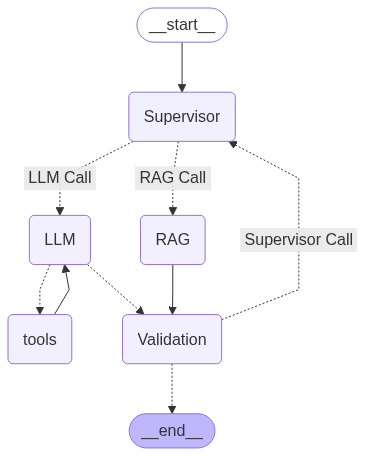

In [43]:
## Create Graph
build = StateGraph(State)
build.add_node('Supervisor',supervisor)
build.add_node('LLM',llm_function)
build.add_node('tools',tool_call)
build.add_node('RAG', rag_function)
build.add_node('Validation', validation_node)

build.add_edge(START, 'Supervisor')
build.add_conditional_edges(
    "Supervisor",
    router,
    {
        'RAG Call':'RAG',
        'LLM Call':'LLM'
    }
)
build.add_conditional_edges(
    'LLM',
    tools_condition,
    {
        'tools':'tools',
        'Validation':'Validation'
    }
)
build.add_edge('tools','LLM')
build.add_edge('RAG','Validation')
build.add_conditional_edges(
    'Validation',
    validation_router,
    {
        END : END,
        'Supervisor Call': 'Supervisor'
    }
)
#build.add_edge('LLM','Validation')
#build.add_edge('LLM',END)
app = build.compile()
app

In [44]:
msg = app.invoke({'messages':['What is langchain']})
if 'Related' in msg['messages']:
    print(msg['messages'][-2])
else:
    print(msg['messages'][-2].content)

What is langchain
Parsed response: Topic='Not Related' Reasoning="The query 'What is langchain' seems to seek basic information about a tool or framework, rather than specifically engaging with LLMs or Transformer architecture."
-->Router-->
last_message:  Not Related 

-->LLM Call-->
['What is langchain', 'Not Related']
-->Tools Condition Router<--
-->LLM Call-->
['What is langchain', 'Not Related', AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KqZBOjpDbzYrQWts3GfiJyQi', 'function': {'arguments': '{"query":"What is langchain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 114, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_finge

In [30]:
msg['messages'][-2]

AIMessage(content='LangChain is an open-source software framework designed to facilitate the integration of large language models (LLMs) into applications. It provides tools and abstractions that help developers create LLM-driven applications, such as chatbots and AI agents, using Python and JavaScript. The framework offers a modular approach, allowing developers to "chain" together various components for building complex natural language processing (NLP) tasks with minimal code. \n\nHere are some key points about LangChain:\n\n1. **Integration of LLMs**: It helps integrate large language models into applications, streamlining the development process.\n2. **Modular Components**: LangChain provides libraries of abstractions representing common tasks and concepts necessary for working with language models. \n3. **Customization and Accuracy**: The framework improves the customization and accuracy of the information generated by LLMs.\n4. **API Usage**: Developers can use simple API calls 